# Features Engineering

Our data can be very high dimensional if we consider the number of languages, countries, actors etc. We have only 44k movies, but we have several hundreds on genres, languages and countries, which gives already around 10 millions possibilities. And this is without even looking at the hundreds of thousands of actors and characters. Thus we have to come up with features that can capture signal in the data, without having to do one-hot encoding for each feature.

## Packages

In [57]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
# ML models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import LatentDirichletAllocation
# Sparse Matrix
from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

sns.set()

## Helpers

In [2]:
CONTINENT_ID = {"North America and Australia": [1,0,0,0,0,0],
"Central and South America": [0,1,0,0,0,0],
"Western Europe": [0,0,1,0,0,0],
"Eastern Europe and Russia": [0,0,0,1,0,0],
"Africa and Middle-East": [0,0,0,0,1,0],
"Asia": [0,0,0,0,0,1]}

COUNTRY_CONTINENT_MAPPING = {
'afghanistan' : "Africa and Middle-East",
 'albania' : "Eastern Europe and Russia",
 'algeria' : "Africa and Middle-East",
 'argentina': "Central and South America",
 'armenia' : "Africa and Middle-East",
 'aruba': "Central and South America",
 'australia': "North America and Australia",
 'austria': "Western Europe",
 'azerbaijan' : "Africa and Middle-East",
 'bahamas': "Central and South America",
 'bahrain' : "Africa and Middle-East",
 'bangladesh': "Asia",
 'belgium': "Western Europe",
 'bhutan': "Asia",
 'bolivia': "Central and South America",
 'bosnia and herzegovina' : "Eastern Europe and Russia",
 'brazil': "Central and South America",
 'bulgaria' : "Eastern Europe and Russia",
 'burkina faso' : "Africa and Middle-East",
 'burma': "Asia",
 'cambodia': "Asia",
 'cameroon' : "Africa and Middle-East",
 'canada': "North America and Australia",
 'chile': "Central and South America",
 'china': "Asia",
 'colombia': "Central and South America",
 'congo' : "Africa and Middle-East",
 'costa rica': "Central and South America",
 'crime' : "Eastern Europe and Russia",
 'croatia' : "Eastern Europe and Russia",
 'cuba': "Central and South America",
 'cyprus' : "Eastern Europe and Russia",
 'czech republic' : "Eastern Europe and Russia",
 'czechoslovakia' : "Eastern Europe and Russia",
 'democratic republic of the congo' : "Africa and Middle-East",
 'denmark': "Western Europe",
 'egypt' : "Africa and Middle-East",
 'estonia' : "Eastern Europe and Russia",
 'ethiopia' : "Africa and Middle-East",
 'finland': "Western Europe",
 'france': "Western Europe",
 'georgia' : "Africa and Middle-East",
 'germany': "Western Europe",
 'greece' : "Eastern Europe and Russia",
 'haiti': "Central and South America",
 'hong kong': "Asia",
 'hungary' : "Eastern Europe and Russia",
 'iceland': "Western Europe",
 'india': "Asia",
 'indonesia': "Asia",
 'iran' : "Africa and Middle-East",
 'iraq' : "Africa and Middle-East",
 'iraqi kurdistan' : "Africa and Middle-East",
 'ireland': "Western Europe",
 'isle of man': "Western Europe",
 'israel' : "Africa and Middle-East",
 'italy': "Western Europe",
 'jamaica': "Central and South America",
 'japan': "Asia",
 'jordan' : "Africa and Middle-East",
 'kenya' : "Africa and Middle-East",
 'korea': "Asia",
 'kuwait' : "Africa and Middle-East",
 'lebanon' : "Africa and Middle-East",
 'libya' : "Africa and Middle-East",
 'lithuania' : "Eastern Europe and Russia",
 'luxembourg': "Western Europe",
 'macau': "Asia",
 'malaysia': "Asia",
 'mali' : "Africa and Middle-East",
 'malta': "Western Europe",
 'mexico': "Central and South America",
 'monaco': "Western Europe",
 'mongolia': "Asia",
 'montenegro' : "Eastern Europe and Russia",
 'morocco' : "Africa and Middle-East",
 'nepal': "Asia",
 'netherlands': "Western Europe",
 'new zealand': "North America and Australia",
 'nigeria' : "Africa and Middle-East",
 'norway': "Western Europe",
 'pakistan' : "Africa and Middle-East",
 'palestinian territories' : "Africa and Middle-East",
 'panama': "Central and South America",
 'peru': "Central and South America",
 'philippines': "Asia",
 'poland' : "Eastern Europe and Russia",
 'portugal': "Western Europe",
 'puerto rico': "Central and South America",
 'republic of macedonia' : "Eastern Europe and Russia",
 'romania' : "Eastern Europe and Russia",
 'russia' : "Eastern Europe and Russia",
 'senegal' : "Africa and Middle-East",
 'serbia' : "Eastern Europe and Russia",
 'serbia and montenegro' : "Eastern Europe and Russia",
 'singapore': "Asia",
 'slovakia' : "Eastern Europe and Russia",
 'slovenia' : "Eastern Europe and Russia",
 'south africa' : "Africa and Middle-East",
 'south korea': "Asia",
 'spain': "Western Europe",
 'sri lanka': "Asia",
 'sweden': "Western Europe",
 'switzerland': "Western Europe",
 'taiwan': "Asia",
 'thailand': "Asia",
 'tunisia' : "Africa and Middle-East",
 'turkey' : "Africa and Middle-East",
 'ukraine' : "Eastern Europe and Russia",
 'united arab emirates' : "Africa and Middle-East",
 'united kingdom': "Western Europe",
 'united states of america': "North America and Australia",
 'uruguay': "Central and South America",
 'uzbekistan' : "Africa and Middle-East",
 'venezuela': "Central and South America",
 'vietnam': "Asia",
 'yugoslavia' : "Eastern Europe and Russia",
 'zambia' : "Africa and Middle-East",
 'zimbabwe' : "Africa and Middle-East"
}

COUNTRY_ENCODING = { 
    "North America and Australia": [1,0,0,0,0,0],
    "Western Europe":              [0,1,0,0,0,0],
    "Asia":                        [0,0,1,0,0,0],
    "Africa and Middle-East":      [0,0,0,1,0,0],
    "Eastern Europe and Russia":   [0,0,0,0,1,0],
    "Central and South America":   [0,0,0,0,0,1]
}

CONTINENT_LIST = ["North America and Australia","Western Europe","Asia",
                  "Africa and Middle-East","Eastern Europe and Russia", 
                  "Central and South America"]

GENRE_MAPPING = {'absurdism': ["comedy"],
 'acid western': ["adventure","action"],
 'action': ["action"],
 'action comedy': ["action","comedy"],
 'action thrillers': ["thriller","action"],
 'action/adventure': ["action","adventure"],
 'addiction drama': ["drama"],
 'adult': ["adult"],
 'adventure': ["adventure"],
 'adventure comedy': ["adventure","comedy"],
 'airplanes and airports': ["other"],
 'albino bias': ["drama"],
 'alien film': ["action","adventure"],
 'alien invasion': ["action"],
 'americana': ["drama"],
 'animal picture': ["other"],
 'animals': ["other"],
 'animated cartoon': ["animation"],
 'animated musical': ["animation"],
 'animation': ["animation"],
 'anime': ["animation"],
 'anthology': ["genre"],
 'anthropology': ["other"],
 'anti-war': ["drama"],
 'anti-war film': ["drama"],
 'apocalyptic and post-apocalyptic fiction': ["action","fantasy"],
 'archaeology': ["other"],
 'archives and records': ["other"],
 'art film': ["genre"],
 'auto racing': ["other"],
 'avant-garde': ["genre"],
 'b-movie': ["comedy"],
 'b-western': ["action","comedy"],
 'backstage musical': ["other"],
 'baseball': ["other"],
 'beach film': ["other"],
 'beach party film': ["comedy"],
 'bengali cinema': ["other"],
 'biker film':["action"],
 'biographical film': ["other"],
 'biography': ["other"],
 'biopic [feature]': ["other"],
 'black comedy': ["comedy"],
 'black-and-white': ["other"],
 'blaxploitation':["drama"],
 'bloopers & candid camera': ["comedy"],
 'bollywood': ["other"],
 'boxing': ["other"],
 'breakdance': ["other"],
 'british empire film': ["other"],
 'british new wave': ["genre"],
 'bruceploitation':["action"],
 'buddy cop': ["action","comedy"],
 'buddy film': ["comedy"],
 'buddy picture': ["comedy"],
 'business': ["other"],
 'camp': ["other"],
 'caper story': ["thriller"],
 'cavalry film': ["action"],
 'chase movie': ["thriller"],
 'childhood drama': ["drama"],
 "children's": ["family"],
 "children's entertainment": ["family"],
 "children's fantasy": ["family","fantasy"],
 "children's issues": ["drama"],
 "children's/family": ["family"],
 'chinese movies': ["other"],
 'christian film': ["other"],
 'christmas movie': ["other"],
 'clay animation': ["animation"],
 'cold war': ["adventure","action"],
 'combat films': ["action"],
 'comdedy': ["comedy"],
 'comedy': ["comedy"],
 'comedy film': ["comedy"],
 'comedy horror': ["horror","comedy"],
 'comedy of errors': ["comedy"],
 'comedy of manners': ["comedy"],
 'comedy thriller': ["thriller","comedy"],
 'comedy western': ["action","comedy"],
 'comedy-drama': ["drama","comedy"],
 'coming of age': ["comedy"],
 'coming-of-age film': ["comedy"],
 'computer animation': ["animation"],
 'computers': ["animation"],
 'concert film': ["other"],
 'conspiracy fiction': ["thriller"],
 'costume adventure': ["adventure"],
 'costume drama': ["drama"],
 'costume horror': ["horror"],
 'courtroom comedy': ["comedy"],
 'courtroom drama': ["drama"],
 'creature film': ["adventure","fantasy"],
 'crime': ["thriller"],
 'crime comedy': ["thriller","comedy"],
 'crime drama': ["thriller","drama"],
 'crime fiction': ["thriller"],
 'crime thriller': ["thriller"],
 'cult': ["other"],
 'culture & society': ["other"],
 'cyberpunk': ["fantasy"],
 'czechoslovak new wave': ["genre"],
 'dance': ["other"],
 'demonic child': ["horror"],
 'detective': ["thriller"],
 'detective fiction': ["thriller"],
 'disaster': ["drama"],
 'docudrama': ["drama"],
 'documentary': ["other"],
 'dogme 95': ["genre"],
 'domestic comedy': ["comedy"],
 'doomsday film': ["fantasy"],
 'drama': ["drama"],
 'dystopia': ["drama","fantasy"],
 'ealing comedies': ["comedy"],
 'early black cinema': ["other"],
 'education': ["family"],
 'educational': ["family"],
 'ensemble film': ["genre"],
 'environmental science': ["other"],
 'epic': ["adventure"],
 'epic western': ["adventure","action"],
 'erotic drama': ["adult","drama"],
 'erotic thriller': ["thriller","adult"],
 'erotica': ["adult"],
 'escape film': ["thriller"],
 'essay film': ["genre"],
 'existentialism': ["genre"],
 'experimental film': ["genre"],
 'exploitation': ["drama"],
 'expressionism': ["genre"],
 'extreme sports': ["other"],
 'fairy tale': ["fantasy","adventure"],
 'family & personal relationships': ["drama"],
 'family drama': ["drama"],
 'family film': ["family"],
 'family-oriented adventure': ["family","adventure"],
 'fan film': ["other"],
 'fantasy': ["fantasy"],
 'fantasy adventure': ["fantasy","adventure"],
 'fantasy comedy': ["fantasy","comedy"],
 'fantasy drama': ["fantasy","drama"],
 'feature film': ["other"],
 'female buddy film': ["comedy"],
 'feminist film': ["drama"],
 'fictional film': ["other"],
 'filipino': ["other"],
 'filipino movies': ["other"],
 'film': ["other"],
 'film & television history': ["other"],
 'film adaptation': ["other"],
 'film noir': ["thriller"],
 'film à clef': ["drama"],
 'film-opera': ["other"],
 'filmed play': ["other"],
 'finance & investing': ["other"],
 'foreign legion':["action"],
 'future noir': ["fantasy","drama"],
 'gangster film': ["thriller","action"],
 'gay': ["drama"],
 'gay interest': ["drama"],
 'gay pornography': ["adult"],
 'gay themed': ["drama"],
 'gender issues': ["drama"],
 'giallo': ["thriller"],
 'glamorized spy film': ["thriller"],
 'goat gland': ["genre"],
 'gothic film': ["genre"],
 'graphic & applied arts': ["genre"],
 'gross out': ["comedy"],
 'gross-out film': ["comedy"],
 'gulf war':["action"],
 'hagiography': ["other"],
 'hardcore pornography': ["adult"],
 'haunted house film': ["horror"],
 'health & fitness': ["other"],
 'heaven-can-wait fantasies': ["fantasy"],
 'heavenly comedy': ["comedy"],
 'heist': ["action"],
 'hip hop movies': ["other"],
 'historical documentaries': ["other"],
 'historical drama': ["drama"],
 'historical epic': ["adventure"],
 'historical fiction': ["other"],
 'history': ["other"],
 'holiday film': ["comedy"],
 'horror': ["horror"],
 'horror comedy': ["horror","comedy"],
 'horse racing': ["other"],
 'humour': ["comedy"],
 'hybrid western': ["adventure","action"],
 'illnesses & disabilities': ["drama"],
 'indian western': ["adventure","action"],
 'indie': ["genre"],
 'inspirational drama': ["drama"],
 'instrumental music': ["other"],
 'interpersonal relationships': ["drama"],
 'inventions & innovations': ["other"],
 'japanese movies': ["other"],
 'journalism': ["other"],
 'jukebox musical': ["other"],
 'jungle film': ["adventure"],
 'juvenile delinquency film': ["drama"],
 'kafkaesque': ["genre"],
 'kitchen sink realism': ["genre"],
 'language & literature': ["genre"],
 'latino': ["other"],
 'law & crime': ["thriller"],
 'legal drama': ["drama"],
 'lgbt': ["drama"],
 'libraries and librarians': ["other"],
 'live action': ["other"],
 'malayalam cinema': ["other"],
 'marriage drama': ["drama"],
 'martial arts film': ["action"],
 'master criminal films': ["thriller"],
 'media satire': ["other"],
 'media studies': ["other"],
 'medical fiction': ["other"],
 'melodrama': ["drama"],
 'mockumentary': ["other"],
 'mondo film': ["genre"],
 'monster': ["horror","action"],
 'monster movie': ["horror","action"],
 'movie serial': ["other"],
 'movies about gladiators': ["other"],
 'mumblecore': ["genre"],
 'music': ["other"],
 'musical': ["other"],
 'musical comedy': ["comedy"],
 'musical drama': ["drama"],
 'mystery': ["thriller"],
 'mythological fantasy': ["fantasy"],
 'natural disaster': ["other"],
 'natural horror films': ["horror"],
 'nature': ["other"],
 'neo-noir': ["thriller"],
 'neorealism': ["genre"],
 'new hollywood': ["genre"],
 'new queer cinema': ["drama"],
 'news': ["other"],
 'ninja movie': ["action"],
 'northern': ["genre"],
 'operetta': ["other"],
 'outlaw': ["other"],
 'outlaw biker film': ["other"],
 'parkour in popular culture': ["action"],
 'parody': ["comedy"],
 'patriotic film': ["other"],
 'period horror': ["horror"],
 'period piece': ["drama"],
 'pinku eiga': ["adult"],
 'plague': ["drama"],
 'point of view shot': ["other"],
 'political cinema': ["other"],
 'political documetary': ["other"],
 'political drama': ["drama"],
 'political satire': ["drama"],
 'political thriller': ["thriller"],
 'pornographic movie': ["adult"],
 'pornography': ["adult"],
 'pre-code': ["other"],
 'prison': ["action"],
 'prison escape': ["action"],
 'prison film': ["action"],
 'private military company': ["action"],
 'propaganda film': ["other"],
 'psycho-biddy': ["horror","thriller"],
 'psychological horror': ["horror"],
 'psychological thriller': ["thriller"],
 'punk rock': ["genre"],
 'race movie': ["action"],
 'reboot': ["other"],
 'religious film': ["other"],
 'remake': ["other"],
 'revenge': ["action"],
 'revisionist fairy tale': ["adventure","fantasy"],
 'revisionist western': ["adventure","action"],
 'road movie': ["other"],
 'road-horror': ["horror"],
 'roadshow theatrical release': ["other"],
 'roadshow/carny': ["other"],
 'rockumentary': ["other"],
 'romance film': ["other"],
 'romantic comedy': ["comedy"],
 'romantic drama': ["drama"],
 'romantic fantasy': ["fantasy"],
 'romantic thriller': ["thriller"],
 'samurai cinema': ["adventure","action"],
 'satire': ["comedy"],
 'school story': ["family"],
 'sci-fi adventure': ["fantasy","adventure"],
 'sci-fi horror': ["fantasy","horror"],
 'sci-fi thriller': ["fantasy","thriller"],
 'science fiction': ["fantasy"],
 'science fiction western': ["adventure","fantasy","action"],
 'screwball comedy': ["comedy"],
 'sex comedy': ["comedy"],
 'sexploitation': ["drama"],
 'short film': ["other"],
 'silent film': ["other"],
 'singing cowboy': ["action","adventure"],
 'slapstick': ["comedy"],
 'slasher': ["horror","action"],
 'slice of life story': ["drama"],
 'social issues': ["drama"],
 'social problem film': ["drama"],
 'softcore porn': ["adult"],
 'space opera': ["fantasy","adventure"],
 'space western': ["adventure","action"],
 'spaghetti western': ["adventure","action"],
 'splatter film': ["horror"],
 'sports': ["other"],
 'spy': ["thriller"],
 'stand-up comedy': ["comedy"],
 'star vehicle': ["other"],
 'steampunk': ["fantasy"],
 'stoner film': ["genre"],
 'stop motion': ["animation"],
 'superhero': ["action"],
 'superhero movie': ["action"],
 'supermarionation': ["animation"],
 'supernatural': ["fantasy"],
 'surrealism': ["genre"],
 'suspense': ["thriller"],
 'swashbuckler films': ["action","adventure"],
 'sword and sandal': ["adventure"],
 'sword and sorcery': ["fantasy","adventure"],
 'sword and sorcery films': ["fantasy","adventure"],
 'tamil cinema': ["other"],
 'teen': ["family"],
 'television movie': ["other"],
 'the netherlands in world war ii': ["action"],
 'therimin music': ["other"],
 'thriller': ["thriller"],
 'time travel': ["adventure"],
 'tokusatsu': ["other"],
 'tollywood': ["other"],
 'tragedy': ["drama"],
 'tragicomedy': ["comedy"],
 'travel': ["adventure"],
 'vampire movies': ["horror","action"],
 'war effort': ["action"],
 'war film': ["action"],
 'werewolf fiction': ["horror"],
 'western': ["adventure","action"],
 'whodunit': ["thriller"],
 'women in prison films': ["drama"],
 'workplace comedy': ["comedy"],
 'world cinema': ["other"],
 'world history': ["other"],
 'wuxia': ["adventure"],
 'z movie': ["horror"],
 'zombie film': ["horror"]}

GENRE_ENCODING = {
    "action":    [1,0,0,0,0,0,0,0,0,0,0],
    "adventure": [0,1,0,0,0,0,0,0,0,0,0],
    "comedy":    [0,0,1,0,0,0,0,0,0,0,0],
    "drama":     [0,0,0,1,0,0,0,0,0,0,0],
    "thriller":  [0,0,0,0,1,0,0,0,0,0,0],
    "horror":    [0,0,0,0,0,1,0,0,0,0,0],
    "animation": [0,0,0,0,0,0,1,0,0,0,0],
    "family":    [0,0,0,0,0,0,0,1,0,0,0],
    "adult":     [0,0,0,0,0,0,0,0,1,0,0],
    "fantasy":   [0,0,0,0,0,0,0,0,0,1,0],
    "genre":     [0,0,0,0,0,0,0,0,0,0,1],
    "other":     [0,0,0,0,0,0,0,0,0,0,0]
}

GENRE_LIST = ["action","adventure","comedy","drama","thriller","horror",
                   "animation","children","adult","fantasy","genre"]

LANGUAGE_FAMILY_MAPPING = {
'aboriginal malays': "Austronesian",
 'afrikaans': "Indo-European",
 'akan': "Atlantic–Congo",
 'albanian': "Indo-European",
 'algonquin': "Unclassified Language",
 'amharic': "Afro-Asiatic",
 'ancient egyptian': "Indo-European",
 'ancient greek': "Indo-European",
 'apache, western': "Unclassified Language",
 'arabic': "Afro-Asiatic",
 'aramaic': "Afro-Asiatic",
 'armenian': "Indo-European",
 'assamese': "Indo-European",
 'assyrian': "Afro-Asiatic",
 'awadhi': "Indo-European",
 'azerbaijani': "Altaic",
 'bambara': "Atlantic–Congo",
 'belarusian': "Indo-European",
 'bengali': "Indo-European",
 'bhojpuri': "Indo-European",
 'bosnian': "Indo-European",
 'brazilian portuguese': "Indo-European",
 'bulgarian': "Indo-European",
 'burmese': "Sino-Tibetan",
 'cantonese': "Sino-Tibetan",
 'catalan': "Indo-European",
 'cebuano': "Austronesian",
 'chadian arabic': "Afro-Asiatic",
 'chechen': "Indo-European",
 'chewa': "Atlantic–Congo",
 'cheyenne': "Unclassified Language",
 'chinese': "Sino-Tibetan",
 'chinese, hakka': "Sino-Tibetan",
 'chinese, jinyu': "Sino-Tibetan",
 'corsican': "Indo-European",
 'cree': "Unclassified Language",
 'croatian': "Indo-European",
 'crow': "Unclassified Language",
 'czech': "Indo-European",
 'danish': "Indo-European",
 'dari': "Indo-European",
 'deutsch': "Indo-European",
 'dutch': "Indo-European",
 'dzongkha': "Sino-Tibetan",
 'egyptian arabic': "Afro-Asiatic",
 'english': "Indo-European",
 'esperanto': "Unclassified Language",
 'estonian': "Indo-European",
 'farsi': "Indo-European",
 'filipino': "Austronesian",
 'finnish': "Indo-European",
 'flemish': "Indo-European",
 'french': "Indo-European",
 'fula': "Atlantic–Congo",
 'fulfulde, adamawa': "Atlantic–Congo",
 'gaelic': "Indo-European",
 'galician': "Indo-European",
 'georgian': "Unclassified Language",
 'german': "Indo-European",
 'greek': "Indo-European",
 'guanzhong hua': "Sino-Tibetan",
 'gujarati': "Indo-European",
 'gumatj': "Unclassified Language",
 'hainanese': "Sino-Tibetan",
 'hariyani': "Indo-European",
 'haryanvi': "Indo-European",
 'hausa': "Afro-Asiatic",
 'hawaiian': "Austronesian",
 'hazaragi': "Indo-European",
 'hebrew': "Afro-Asiatic",
 'hiligaynon': "Austronesian",
 'hindi': "Indo-European",
 'hindustani': "Indo-European",
 'hinglish': "Indo-European",
 'hmong': "Sino-Tibetan",
 'hokkien': "Sino-Tibetan",
 'hopi': "Unclassified Language",
 'hungarian': "Indo-European",
 'hungary': "Indo-European",
 'icelandic': "Indo-European",
 'indonesian': "Austronesian",
 'inuktitut': "Unclassified Language",
 'irish': "Indo-European",
 'italian': "Indo-European",
 'japan': "Altaic",
 'japanese': "Altaic",
 'judeo-georgian': "Unclassified Language",
 'kannada': "Dravidian",
 'khmer': "Austronesian",
 'kinyarwanda': "Atlantic–Congo",
 'klingon': "Unclassified Language",
 'korean': "Altaic",
 'krio': "Indo-European",
 'kurdish': "Indo-European",
 'latin': "Indo-European",
 'lithuanian': "Indo-European",
 'luxembourgish': "Indo-European",
 'macedonian': "Indo-European",
 'malay': "Austronesian",
 'malayalam': "Dravidian",
 'mandarin': "Sino-Tibetan",
 'maninka': "Atlantic–Congo",
 'marathi': "Indo-European",
 'maya, yucatán': "Unclassified Language",
 'mende': "Atlantic–Congo",
 'min nan': "Sino-Tibetan",
 'mohawk': "Unclassified Language",
 'mongolian': "Altaic",
 'māori': "Austronesian",
 'nahuatls': "Unclassified Language",
 'napoletano-calabrese': "Indo-European",
 'navajo': "Unclassified Language",
 'nepali': "Indo-European",
 'norwegian': "Indo-European",
 'old english': "Indo-European",
 'oriya': "Indo-European",
 'palawa kani': "Unclassified Language",
 'papiamento': "Indo-European",
 'pashto': "Indo-European",
 'pawnee': "Unclassified Language",
 'persian': "Indo-European",
 'plautdietsch': "Indo-European",
 'polish': "Indo-European",
 'portuguese': "Indo-European",
 'punjabi': "Indo-European",
 'quechua': "Unclassified Language",
 'rajasthani': "Indo-European",
 'romani': "Indo-European",
 'romanian': "Indo-European",
 'russian': "Indo-European",
 'saami, north': "Indo-European",
 'samis': "Atlantic–Congo",
 'sanskrit': "Indo-European",
 'scanian': "Indo-European",
 'scottish gaelic': "Indo-European",
 'serbian': "Indo-European",
 'serbo-croatian': "Indo-European",
 'shanghainese': "Sino-Tibetan",
 'shanxi': "Sino-Tibetan",
 'sicilian': "Indo-European",
 'sign': "Silent",
 'silent film': "Silent",
 'sinhala': "Indo-European",
 'sioux': "Unclassified Language",
 'slovak': "Indo-European",
 'slovenian': "Indo-European",
 'somali': "Afro-Asiatic",
 'sotho': "Atlantic–Congo",
 'spanish': "Indo-European",
 'sumerian': "Unclassified Language",
 'sunda': "Austronesian",
 'swahili': "Atlantic–Congo",
 'swedish': "Indo-European",
 'swiss german': "Indo-European",
 'tagalog': "Austronesian",
 'taiwanese': "Sino-Tibetan",
 'tamil': "Dravidian",
 'telugu': "Dravidian",
 'teochew': "Sino-Tibetan",
 'thai': "Austronesian",
 'tibetan': "Sino-Tibetan",
 'tibetans': "Sino-Tibetan",
 'tok pisin': "Indo-European",
 'tulu': "Dravidian",
 'turkish': "Indo-European",
 'tuu': "Unclassified Language",
 'tzotzil': "Unclassified Language",
 'ukrainian': "Indo-European",
 'urdu': "Indo-European",
 'venetian': "Indo-European",
 'vietnamese': "Austronesian",
 'welsh': "Indo-European",
 'wolof': "Atlantic–Congo",
 'xhosa': "Atlantic–Congo",
 'yiddish': "Indo-European",
 'yolngu matha': "Austronesian",
 'zulu': "Atlantic–Congo"
}

LANGUAGE_FAMILY_LIST = ["Afro-Asiatic","Altaic","Atlantic–Congo","Austronesian","Dravidian",
                        "Indo-European","Silent","Sino-Tibetan","Unclassified Language"]

LANGUAGUE_ENCODING = {
    "Afro-Asiatic": [1,0,0,0,0,0,0,0,0],
    "Altaic": [0,1,0,0,0,0,0,0,0],
    "Atlantic–Congo": [0,0,1,0,0,0,0,0,0],
    "Austronesian": [0,0,0,1,0,0,0,0,0],
    "Dravidian": [0,0,0,0,1,0,0,0,0],
    "Indo-European": [0,0,0,0,0,1,0,0,0],
    "Silent": [0,0,0,0,0,0,1,0,0],
    "Sino-Tibetan": [0,0,0,0,0,0,0,1,0],
    "Unclassified Language": [0,0,0,0,0,0,0,0,1]
}

# These parameters control the formation of the dataframe for regression
# drop: Columns to drop before applying any transform to the data
# nan_filtering: Columns on which we want to remove rows with nans.
#                If 'all', then apply on every one.
# decades: List of decades on which to apply the regression. 
#          If empty list then all decades will be taken.
# log: Columns on which to apply a log transform.
# standardize: Columns to standardize.
# post_drop: Columns to drop before doing the regression.
DEFAULT_PARAMETERS = {
            "drop": ["name","revenue","has_common_character_name","character_number"],
            "nan_filtering":["all"],
            "decades":[],
            "log":[],
            "standardize":["title_length"],
            "post_drop": ["release_date","num_votes",
                            "runtime","decade","average_rating",
                            "combinned_best_rating"]}

SUCCESS_THRESHOLD = 6.5

NE_FULL_LIST = ["ORGANIZATION","PERSON","LOCATION",
                "DATE","TIME","MONEY",
                "PERCENT","FACILITY","GPE"]

EPSILON = 1e-4 # Set to 1e-4 empirically, but idea is to have at least one occurence in all corpus

## Load Data

In [3]:
country_df = pd.read_pickle("../../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")
is_directed_by_df = pd.read_pickle("../../data/post_processing/is_directed_by_df.pkl")
director_df = pd.read_pickle("../../data/post_processing/director_df.pkl")

## Create Regression DataFrame

In [4]:
movie_regression_df = movie_df.copy()
movie_regression_df.drop(["freebase_id","plot"],axis=1,inplace=True)
movie_regression_df["num_votes"] = movie_regression_df["num_votes"].astype(np.int32)

## Countries

For the countries we can already try to group per continent. It will give an idea of the different local influence without going in too much details. We suggest the following partition based on our previous analysis:

- North America and Australia
- Central and South America
- Western Europe
- Eastern Europe and Russia
- Africa and Middle-East
- Asia

In [5]:
country_movie_df = comes_from_df.copy()
country_movie_df["country_encoding"] = country_movie_df["country_name"].apply(
    lambda c: COUNTRY_CONTINENT_MAPPING[c])
country_movie_df["country_encoding"] = country_movie_df["country_encoding"].apply(
    lambda c: np.array(COUNTRY_ENCODING[c]))
for continent in CONTINENT_LIST:
    country_movie_df[continent] = country_movie_df["country_encoding"].apply(
        lambda l: l[CONTINENT_LIST.index(continent)])
    movie_regression_df[continent] = country_movie_df.groupby("movie_id")[continent].max()

## Actors

For the actors, we thought about the following features:
- #number of actors in the top 5% (or 1% ?)
- #number of actors
- mean actor age
- gender balance

In [6]:
percentile = 99
actor_movie_count = appears_in_df.groupby("actor_id")["movie_id"].count().values
threshold = np.percentile(actor_movie_count,percentile)
is_actor_above_threshold = appears_in_df.groupby("actor_id")["movie_id"].count().sort_index() >= threshold
top_k_actors = actor_df[is_actor_above_threshold.values]
print(f"There are {len(top_k_actors)} actors in the top {percentile}%.")

There are 1014 actors in the top 99%.


In [7]:
actor_movie_df = appears_in_df.merge(actor_df["gender"],how="left",on="actor_id")
actor_movie_df["gender"] = actor_movie_df["gender"].apply(
    lambda g: -1 if g == "M" else 1 if g == "F" else g)
actor_movie_df["is_top_k"] = actor_movie_df["actor_id"].isin(set(top_k_actors.index))

In [8]:
movie_regression_df["actor_number"] = actor_movie_df.groupby("movie_id")["actor_id"].count()
movie_regression_df["mean_actor_age"] = actor_movie_df.groupby("movie_id")["actor_age"].mean()
movie_regression_df["gender_ratio"] = actor_movie_df.groupby("movie_id")["gender"].mean()
movie_regression_df["has_famous_actor"] = actor_movie_df.groupby("movie_id")["is_top_k"].max()
movie_regression_df["has_famous_actor"] = movie_regression_df["has_famous_actor"].replace({True: 1, False: 0})

## Genre

For the genre we suggest the following features:
- #genres
- One-hot-encoding of genre cluster:
    - action
    - adventure
    - comedy
    - drame
    - thriller
    - horror
    - animation
    - children
    - adult
    - fantasy
    - genre
    - other

In [9]:
genre_movie_df = is_of_type_df.copy()
genre_movie_df["genre_encoding"] = genre_movie_df["genre_name"].apply(lambda g: GENRE_MAPPING[g])
genre_movie_df["genre_encoding"] = genre_movie_df["genre_encoding"].apply(
    lambda l: np.sum([np.array(GENRE_ENCODING[g]) for g in l],axis=0))
for genre in GENRE_LIST:
    genre_movie_df[genre] = genre_movie_df["genre_encoding"].apply(
        lambda l: l[GENRE_LIST.index(genre)])
    movie_regression_df[genre] = genre_movie_df.groupby("movie_id")[genre].max()
movie_regression_df["genre_number"] = genre_movie_df.groupby("movie_id")["genre_name"].count()

## Languages

For the languages we can try to group per language family. It will give an idea of the different influence of a common ancestral language without going in too much details. We suggest the following partition based on our previous analysis:
- Afro-Asiatic
- Altaic
- Atlantic–Congo
- Austronesian
- Dravidian
- Indo-European
- Silent
- Sino-Tibetan
- Unclassified Language

In [10]:
language_movie_df = spoken_languages_df.copy()
language_movie_df["language_encoding"] = language_movie_df["language_name"].apply(
    lambda c: LANGUAGE_FAMILY_MAPPING[c])
language_movie_df["language_encoding"] = language_movie_df["language_encoding"].apply(
    lambda c: np.array(LANGUAGUE_ENCODING[c]))
for language_family in LANGUAGE_FAMILY_LIST:
    language_movie_df[language_family] = language_movie_df["language_encoding"].apply(
        lambda l: l[LANGUAGE_FAMILY_LIST.index(language_family)])
    movie_regression_df[language_family] = language_movie_df.groupby("movie_id")[language_family].max()

## Characters
- #characters
- usage of common names

In [11]:
k_characters = 20
top_k_characters_names = set(character_df["character_name"].value_counts().head(k_characters).index)
top_k_characters_ids = set(character_df[character_df["character_name"].isin(top_k_characters_names)].index)
character_movie_df = belongs_to_df.copy()
character_movie_df["common_character_name"] = character_movie_df["character_id"].isin(top_k_characters_ids)
movie_regression_df["has_common_character_name"] = character_movie_df.groupby(
    "movie_id")["common_character_name"].max()
movie_regression_df["character_number"] = character_movie_df.groupby(
    "movie_id")["character_id"].count()
movie_regression_df["has_common_character_name"] = movie_regression_df[
    "has_common_character_name"].replace({True: 1, False: 0})

## Decade

In [12]:
movie_regression_df["decade"] = movie_regression_df["release_date"].apply(lambda d: d.year - d.year%10)

## Movie Title

In [13]:
movie_regression_df["title_length"] = movie_regression_df["name"].apply(lambda n: len(n.split()))

## Director

- Has the director produced a successful movie in the past decades
- Has the director produced a successful movie in the past (coarser feature)
- Number of movies produced by directors in the past

- Number of directors on the movie

In [14]:
def director_metrics_up_to_date(movie_dataframe: pd.DataFrame, director_movies: set, date) -> tuple:
    """
    Compute the number of movies and the best ratings up to the date from the set of movies provided.
    
    This function allows us to have the history of performance of the set of directors that worked 
    on a given movie. You give the set of movies of the directors and the date of production of the
    current movie and it will return the performance up to the given date.
    
    :param movie_dataframe: Pandas DataFrame with movie information
    :param director_movies: Set of movies directed by the directors of the current movie.
    :param date: Date of release of the current movie, thus the metrics are up to this date.
    
    :return: The number of movies and the best rating up to the given date.
    """
    director_movie_df = movie_dataframe[movie_dataframe.index.isin(director_movies)]
    movie_date_df = director_movie_df[director_movie_df["release_date"] < date]
    movie_count = len(movie_date_df)
    if movie_count == 0:
        return 0, None
    best_rating = movie_date_df["average_rating"].max()
    return movie_count, best_rating

In [15]:
director_movies_mapping = is_directed_by_df.groupby("director_id")["movie_id"].apply(set).to_dict()

In [16]:
# Compute the set of movies directed by the directors for each movie
director_movies_df = is_directed_by_df.copy()
director_movies_df["director_movies"] = director_movies_df["director_id"].apply(
    lambda d: director_movies_mapping[d])
director_movies_df = director_movies_df.groupby("movie_id")["director_movies"].apply(list)
director_movies_df = director_movies_df.apply(
    lambda movie_list: set([m for movie_set in movie_list for m in list(movie_set)]))
director_movies_df = pd.DataFrame(director_movies_df)
# Merge DataFrames to recover temporal data and rating
new_is_directed_by_df = director_movies_df.merge(
    movie_regression_df[["average_rating","release_date"]],how="left",on="movie_id")
new_is_directed_by_df["combined_features"] = list(zip(new_is_directed_by_df["director_movies"],new_is_directed_by_df["release_date"]))
# Compute performance of the movie directing team up to the release date of each movie.
new_is_directed_by_df["director_metrics"] = new_is_directed_by_df["combined_features"].apply(
    lambda t: director_metrics_up_to_date(new_is_directed_by_df,t[0],t[1]))

In [17]:
movie_regression_df["combinned_movie_num"] = new_is_directed_by_df["director_metrics"].apply(lambda t: t[0])
movie_regression_df["combinned_best_rating"] = new_is_directed_by_df["director_metrics"].apply(lambda t: t[1])
movie_regression_df["num_directors"] = is_directed_by_df.groupby("movie_id").count()

In [18]:
movie_regression_df["combinned_movie_success"] = movie_regression_df["combinned_best_rating"] > SUCCESS_THRESHOLD
movie_regression_df["combinned_movie_success"] = movie_regression_df[
    "combinned_movie_success"].replace({True: 1, False: 0})

---

## Plot

The plot of the movie is certainly a key element in its final quality. Thus we will try to comes with summary features.

We will base our analysis on the BOW matrix, which is constructed in the following way:
- Preprocess plots: tokenization + casefolding + stopwords and Named Entity removal + lemmatization
- BOW creation
- BOW matrix creation

Then we will extract the following features:
- Odds ratio computation in order to capture terms that are more frequent in popular (high ratio) or unpopular (low ratio) movies.
- LDA topic extraction, to add a second layer of potential topic but more coarsed and dataset tailored.

### Load Locally

The processing of the dataset takes some time. Thus you can load directly the following files that will save you the cost of the preprocessing.

Once done you can directly jump to the Odds Ratio section.

In [19]:
# Load data
movies_with_plot_df = pd.read_pickle("../../data/post_processing/plot_df.pkl")
BOW_matrix = load_npz("../../data/post_processing/BOW_matrix.npz")
with open("../../data/post_processing/BOW_mapping.pkl", 'rb') as handle:
    BOW_dict = pickle.load(handle)
reversed_BOW_dict = {v:k for k,v in BOW_dict.items()}

---

### Odds ratio

In [20]:
def compute_term_frequency(matrix: csr_matrix, epsilon=EPSILON, doc_freq=False, hard_clip=False):
    """
    Compute the term frequency of words in the given BOW matrix.
    
    :param matrix: Scipy sparse BOW matrix.
    :param epsilon: Smoothing parameter.
    :param doc_freq: Indicator if the term frequency should be multiplied by the doc_freq.
                     It gives more weights to terms that appear in many documents.
    :param hard_clip: Indicator if the frequency in a term should be capped to 1.
                     Similar to doc_freq, it avoid bias toward docs with lot of repetitions.
    
    :return: Numpy array containing the smoothed term frequency.
    """
    tf = np.array(matrix.sum(axis=0).tolist()[0])
    tf = (tf+EPSILON)/tf.sum()
    if hard_clip:
        capped_occurence = matrix.copy()
        capped_occurence[capped_occurence>1] = 1
        tf = np.array(capped_occurence.sum(axis=0).tolist()[0])
        tf = (tf+EPSILON)/tf.sum()
        return tf
    elif doc_freq:
        capped_occurence = matrix.copy()
        capped_occurence[capped_occurence>1] = 1
        doc_number = epsilon+np.array(capped_occurence.sum(axis=0).tolist()[0])
        return doc_number*tf
    else:
        return tf
    
def get_top_k_terms(tf_popular: np.array, tf_unpopular: np.array,
                    reversed_BOW_dictionnary: dict, k=30,
                    bad_movie=False):
    """
    Print the terms with the highest or lowest odd ratio in the data.
    
    :param tf_popular: Term frequency for popular movies.
    :param tf_unpopular: Term frequency for unpopular movies.
    :param reversed_BOW_dictionnary: Dictionnary of term index with word string.
    :param k: Number of terms to retrieve.
    :param bad_movie: Indicator if should return the lowest log odds, so best term for bad movies.
    
    """
    # Log odds
    log_odds = np.log(tf_popular/tf_unpopular)
    if bad_movie:
        log_odds = -log_odds
    top_k_ids = np.argpartition(log_odds, -k)[-k:]
    top_log_odds = sorted([(idx,log_odds[idx]) for idx in top_k_ids],key=lambda l: -l[1])
    print(f"The top {k} terms with the highest log odds are:")
    for idx, value in top_log_odds:
        print(f"\t-{reversed_BOW_dict[idx]}: {value}")

In [21]:
popular_row_ids = (movies_with_plot_df.merge(movie_regression_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] > SUCCESS_THRESHOLD).values
unpopular_row_ids = ~popular_row_ids

In [22]:
# An alternative is to do an harder filtering on the movies we want to consider rather than simple
# one sided threshold.
popular_row_ids = (movies_with_plot_df.merge(movie_regression_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] > 8.5).values
unpopular_row_ids = (movies_with_plot_df.merge(movie_regression_df["average_rating"],how="left",on="movie_id"
                         ).reset_index()["average_rating"] < 4.5).values

In [23]:
# Term frequency for popular movies with smoothing term
tf_popular_movies = compute_term_frequency(BOW_matrix[popular_row_ids,:],
                                           doc_freq=False,hard_clip=False)
# Term frequecy for unpopular movies with smoothing term
tf_unpopular_movies = compute_term_frequency(BOW_matrix[unpopular_row_ids,:],
                                             doc_freq=False,hard_clip=False)

In [24]:
get_top_k_terms(tf_popular_movies,tf_unpopular_movies,reversed_BOW_dict,k=30,bad_movie=True)

The top 30 terms with the highest log odds are:
	-alien: 12.129503607433069
	-scientist: 12.007336038430578
	-monster: 11.787013502711522
	-strange: 11.772828877779922
	-zombie: 11.456159534561106
	-vampire: 11.330996522325917
	-base: 11.308523691726355
	-wood: 11.29709500896437
	-shark: 11.225636130124736
	-unfortunately: 11.213213625558257
	-animal: 11.200634859174164
	-experiment: 11.148675187753913
	-lab: 11.121646551895624
	-box: 11.121646551895624
	-stab: 11.079682411504924
	-underground: 11.05069491664842
	-talking: 11.05069491664842
	-mask: 11.035879852812323
	-expedition: 11.02084199806195
	-jungle: 10.925531969772537
	-california: 10.908724879704694
	-treasure: 10.891630475568022
	-robot: 10.874238763104135
	-dad: 10.874238763104135
	-drink: 10.856539217333
	-investigation: 10.838520744297794
	-castle: 10.838520744297794
	-sequence: 10.801479541227952
	-sheriff: 10.801479541227952
	-helicopter: 10.78243138254166


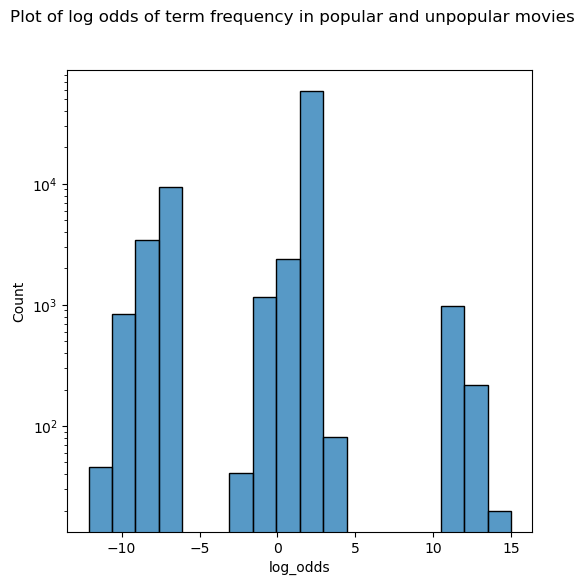

In [25]:
# Log odds
log_odds = np.log(tf_popular_movies/tf_unpopular_movies)
# Plot
fig,ax = plt.subplots(figsize=(6,6))
fig.suptitle("Plot of log odds of term frequency in popular and unpopular movies")
ax.set_xlabel("log_odds")
ax.set_yscale("log")
sns.histplot(log_odds,ax=ax);

---

### LDA

In [29]:
LDA = LatentDirichletAllocation(n_components=10)
LDA_fit = LDA.fit(BOW_matrix);

In [30]:
words_nb = 15
test_movie_id = 3
test_movie = BOW_matrix[test_movie_id,:].reshape(1,len(BOW_dict))
topic = np.argmax(LDA_fit.transform(test_movie))
top_words_ids = np.argpartition(LDA_fit.components_[topic,:], -words_nb)[-words_nb:]
for word_id in top_words_ids:
    print(list(BOW_dict)[word_id], LDA_fit.components_[topic,word_id])
print("\n\n",movie_regression_df.loc[movie_regression_df.index[test_movie_id]])
print("\n\n",is_of_type_df[is_of_type_df["movie_id"] == movie_regression_df.index[test_movie_id]])

see 5792.634496778496
back 6177.066372217113
father 7406.381398054844
home 7383.745125589186
love 7175.401300733106
friend 7163.095790273497
find 7493.856645041415
day 6829.758240703953
mother 7475.657338660215
life 6249.1590242579905
go 9646.942122050012
get 8034.110727783174
tell 9287.12301421722
take 6218.21860859183
one 7108.406737198158


 name                           Alexander's Ragtime Band
release_date                        1938-08-16 00:00:00
revenue                                       3600000.0
runtime                                           106.0
average_rating                                      6.9
num_votes                                          2160
North America and Australia                         1.0
Western Europe                                      0.0
Asia                                                0.0
Africa and Middle-East                              0.0
Eastern Europe and Russia                           0.0
Central and South America            

---

## Add term

In [31]:
def add_word_to_regression(regression_dataframe: pd.DataFrame,
                           plot_dataframe: pd.DataFrame,
                           word: str, BOW_dict: dict, binarize=True):
    """
    Add the occurence of the given term as a feature in the regression dataframe.
    
    :param regression_df: Pandas DataFrame containing the data for regression.
    :param plot_dataframe: Pandas DataFrame with the plot processing data.
    :param word: Word to integrate in the regression dataframe.
    :param BOW_dict: Dictionnary containing the mapping between words and ids in the BOW matrix.
    :param binarize: Indicator if the output should be a single binary variable for the 
                    occurence of the word in the movie rather than the number of occurences
    
    """
    movie_has_term_series = plot_dataframe["encoding"].apply(
        lambda bow: bow[BOW_dict[word]] if BOW_dict[word] in bow else 0)
    if binarize:
        movie_has_term_series = movie_has_term_series > 0
    regression_dataframe[f"plot_has_{word}"] = movie_has_term_series

In [32]:
a = movie_regression_df.copy()
add_word_to_regression(a, movies_with_plot_df, "underground", BOW_dict, binarize=False)

---

## Genre Analysis

In [34]:
rating_genre = movie_regression_df.filter(GENRE_LIST+["average_rating"])
rating_genre = rating_genre[GENRE_LIST].multiply(rating_genre["average_rating"], axis=0)

In [35]:
sum_rating_genre = pd.merge(rating_genre, movie_regression_df, on="movie_id", suffixes=(None, "_y"))[GENRE_LIST+["decade"]].groupby("decade").sum()

In [36]:
sum_nb_genre = movie_regression_df[GENRE_LIST+["decade"]].groupby("decade").sum()

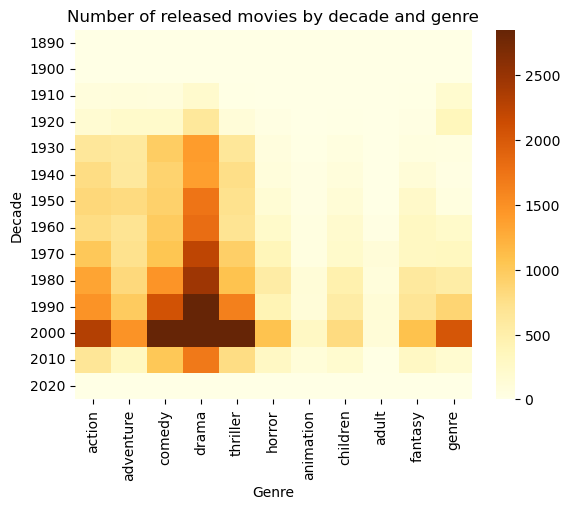

In [37]:
sns.heatmap(sum_nb_genre, robust=True, square=False, cmap="YlOrBr")
plt.title("Number of released movies by decade and genre")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.show()

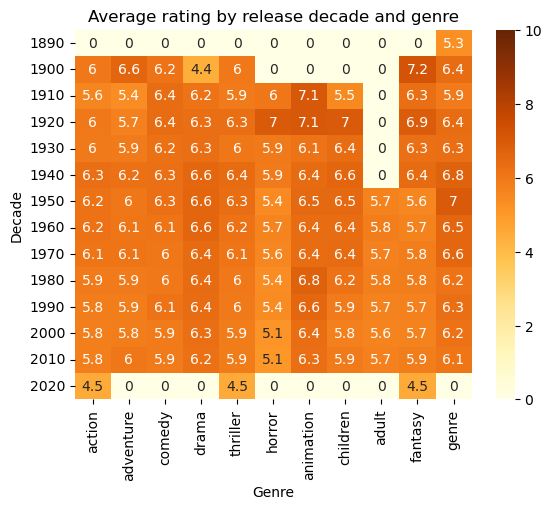

In [38]:
sns.heatmap(sum_rating_genre.divide(sum_nb_genre).fillna(0), robust=False, square=False, annot=True, vmin=0, vmax=10, cmap="YlOrBr")
plt.title("Average rating by release decade and genre")
plt.xlabel("Genre")
plt.ylabel("Decade")
plt.show()

---

## Gender Ratio

In [39]:
gender_ratio = movie_regression_df.dropna(subset=['gender_ratio', 'decade'])

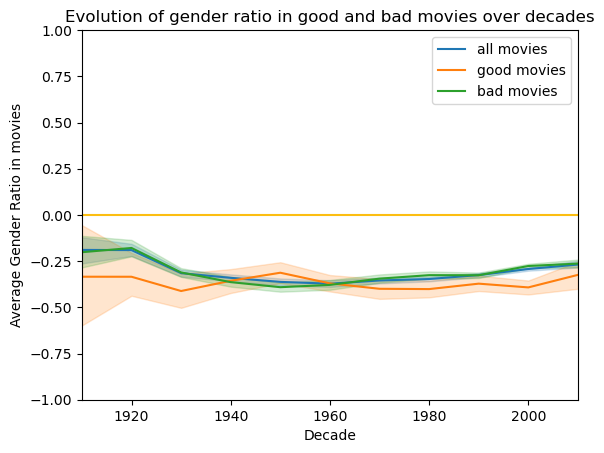

In [40]:
sns.lineplot(data=gender_ratio, x='decade', y='gender_ratio',legend='brief', label='all movies')
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] > 7.5], x='decade', y='gender_ratio',legend='brief', label='good movies')
sns.lineplot(data=gender_ratio[gender_ratio['average_rating'] < 6.5], x='decade', y='gender_ratio',legend='brief', label='bad movies')
plt.axhline(0, color='#fcbe11')
plt.xlabel('Decade')
plt.ylabel('Average Gender Ratio in movies')
plt.xlim([1910, 2010])
plt.ylim([-1, 1])
plt.title('Evolution of gender ratio in good and bad movies over decades')
plt.legend()
plt.show()

---

## Director success through a KM analysis

In [41]:
movie_director = pd.merge(pd.merge(director_df, is_directed_by_df, on='director_id'), movie_df, on='movie_id')[['director_id', 'birth_year', 'death_year', 'release_date', 'average_rating']]
movie_director.dropna(inplace=True)

movie_director['release_year'] = movie_director['release_date'].dt.year
movie_director.drop(['release_date'], axis=1, inplace=True)

movie_director['director_age'] = (movie_director['release_year'] - movie_director['birth_year'])
movie_director = movie_director[movie_director['director_age'] > 18]

# a movie is a success if rating higher than threshold and release before director's death
movie_director['success'] = np.where((movie_director.average_rating > SUCCESS_THRESHOLD) & (movie_director.release_year < movie_director.death_year),1,0)

movie_director.head()

,director_id,birth_year,death_year,average_rating,release_year,director_age,success
0,nm0000005,1918,2007,7.7,1955,37,1
1,nm0000005,1918,2007,7.2,1950,32,1
2,nm0000005,1918,2007,7.1,1960,42,1
3,nm0000005,1918,2007,7.6,1982,64,1
4,nm0000005,1918,2007,6.4,1948,30,0


In [43]:
directors = {}
for director, group in movie_director.groupby(['director_id', 'success']):        
    if director[1] == 1:
        directors[director[0]] = [1, group["director_age"].min()]
    else:
        if director[0] in directors:
            continue
        else:
            directors[director[0]] = [0, group["director_age"].max()]
director_km = pd.DataFrame(directors).transpose()
director_km.rename(columns={director_km.columns[0]: 'success', director_km.columns[1]: 'success_age'}, inplace=True)

In [44]:
director_sf = sm.SurvfuncRight(director_km["success_age"], director_km["success"])

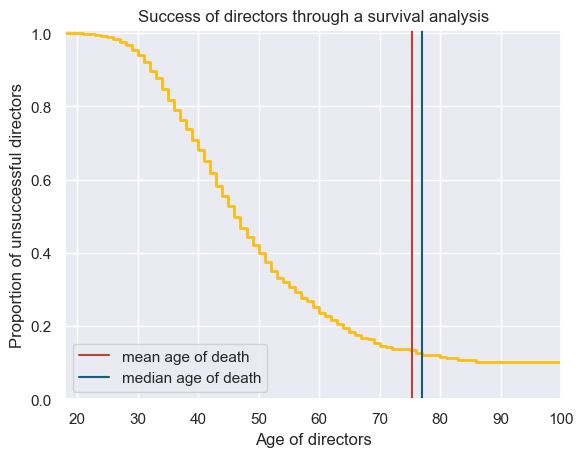

In [59]:
fig = director_sf.plot()
ax = fig.get_axes()[0]
pt = ax.get_lines()[1]
pt.set_visible(False)
ax.get_lines()[0].set_color("#fcbe11")
mean = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).mean(), label='mean age of death', color='#bb4430')
median = ax.axvline((movie_director['death_year'] - movie_director['birth_year']).median(), label='median age of death', color='#185c77')
plt.xlim([18, 100])
plt.title("Success of directors through a survival analysis")
plt.xlabel("Age of directors")
plt.ylabel("Proportion of unsuccessful directors")
plt.legend(handles=[mean, median])
plt.show()

In [47]:
print(f"The mean age of director deaths is {(movie_director['death_year'] - movie_director['birth_year']).mean(): .2f}, and the median age is {(movie_director['death_year'] - movie_director['birth_year']).median(): .2f}.")

The mean age of director deaths is  75.35, and the median age is  77.00.


---

## Regression Analysis

In [48]:
def standardize_column(dataframe: pd.DataFrame, col_name: str):
    """
    Standardize the given column in the provided dataframe.
    
    :param dataframe: Pandas DataFrame containing the data.
    :param col_name: Name of the column to standardize.
    
    """
    dataframe[col_name] = (dataframe[col_name]-
        dataframe[col_name].mean())/dataframe[col_name].std()
    
def process_dataframe(dataframe: pd.DataFrame,
                      parameters={"drop": [], "nan_filtering":["all"],"decades":[],
                                  "log":[], "standardize":[]}) -> pd.DataFrame:
    """
    Pre-process the dataframe for regression given the instructions in parameters.
    
    :param dataframe: Pandas DataFrame with the movie data for regression
    :param parameters: Dictionnary with the different parameters for pre-processing:
                            - drop: List of columns to drop.
                            - nan_filtering: List of columns where nan rows should be excluded.
                            - decades: List of decades to keep. If empty, keep all decades.
                            - log: List of columns to log transform.
                            - standardize: List of columns to standardize.
                    
    
    :return: Processed Pandas DataFrame ready for regression.
    
    """
    regression_df = dataframe.copy()
    # Filter out columns
    regression_df = regression_df.drop(parameters["drop"],axis=1)
    # Filter out decades
    if len(parameters["decades"]) != 0:
        regression_df = regression_df[
            regression_df["decade"].isin(parameters["decades"])]
    # Filter out NaN
    if len(parameters["nan_filtering"]) != 0:
        if parameters["nan_filtering"][0] == "all":
            regression_df = regression_df.dropna(how="any")
        else:
            regression_df = regression_df.dropna(subset=parameters["nan_filtering"])
    # Transform
    for col in parameters["log"]:
        regression_df["log_"+col] = regression_df[col].apply(np.log)
    # Standardize
    for col in parameters["standardize"]:
        standardize_column(regression_df,col)
    return regression_df

In [49]:
def select_next_feature(regression_df: pd.DataFrame, target: pd.Series,
                        current_features=[], ignored_features=[], 
                        alpha=0.05, show=False, log_reg=False) -> str:
    """
    Report the best feature to integrate to the current OLS model based on r-squared.
    
    :param regression_df: Pandas DataFrame containing the data for regression.
    :param target: Pandas Series representing the target values.
    :param current_features: List of features integrated in the actual model.
    :param ignored_features: List of features that should not be integrated in the regression.
    :param alpha: Significance level, default 0.05.
    :param show: Display the different features scores.
    :param log_reg: Indicator to perform a logistic regression instead of linear regression.
    
    :result: Name of the best feature or None if no new significant features.
    
    """
    result_dict = {'predictor': [], "aic":[], "p_value":[]}
    if not log_reg:
        result_dict['r-squared'] = []
    for col in regression_df.columns:
        if col not in (current_features+ignored_features):
            X = regression_df[current_features + [col]]
            if log_reg:
                model = sm.Logit(binary_target, sm.add_constant(X)).fit()
            else:
                model = sm.OLS(target, sm.add_constant(X)).fit()
            #Add the column name to our dictionary
            result_dict['predictor'].append(col)
            if not log_reg:
                #Calculate the r-squared value between the target and predicted target
                r2 = model.rsquared
                result_dict['r-squared'].append(r2)
            #Add the model metrics to our dictionary
            result_dict['aic'].append(model.aic)
            result_dict['p_value'].append(model.pvalues.loc[col])
    #Once it's iterated through every column, turn our dict into a sorted DataFrame
    candidates_features = pd.DataFrame(result_dict).sort_values(by=['aic'],
                                                          ascending = True)
    if show:
        display(candidates_features.head())
        
    candidates_features = candidates_features[candidates_features["p_value"] < alpha]
    if len(candidates_features) == 0:
        return "None"
    else:
        return candidates_features["predictor"].iloc[0]

In [50]:
def forward_selection(regression_df: pd.DataFrame, target: pd.Series,
                        ignored_features=[], alpha=0.05, show=False,
                        log_reg=False) -> list:
    """
    Iterative forward feature selection based on r-squared without interaction terms.
    
    :param regression_df: Pandas DataFrame containing the data for regression.
    :param target: Pandas Series representing the target values.
    :param current_features: List of features integrated in the actual model.
    :param ignored_features: List of features that should not be integrated in the regression.
    :param alpha: Significance level, default 0.05.
    :param show: Display the different features scores.
    :param log_reg: Indicator to perform a logistic regression instead of linear regression.
    
    :result: List of the best features to model the target.
    
    """
    last_feature = ""
    current_features = []
    while ((len(ignored_features) + len(current_features)) < len(regression_df)
           and last_feature != "None"):
        last_feature = select_next_feature(regression_df, target,
                        current_features=current_features,
                        ignored_features=ignored_features, 
                        alpha=alpha, show=show, log_reg=log_reg)
        if last_feature != "None":
            current_features.append(last_feature)
    return current_features

In [51]:
def create_VIF_dataframe(regression_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the VIF for each features in the given dataframe.
    
    :param regression_df: Pandas DataFrame containing the data for regression.
    
    :return: Pandas DataFrame with the VIF for each features.
    
    """
    vif_features = regression_df.columns
    vif_values = [variance_inflation_factor(regression_df.values, i) 
                for i in range(len(regression_df.columns))]
    vif_df = pd.DataFrame(np.array([vif_features,vif_values]).T,columns=["predictor","VIF"])
    return vif_df

def filter_multicolinearity(regression_df: pd.DataFrame, threshold=5):
    """
    Remove the features that shows high multicollinearity based on VIF.
    
    :param regression_df: Pandas DataFrame containing the data for regression.
    :param threshold: Threshold above which a VIF is considered to high to be kept. 
    
    :return: Pandas DataFrame with data for regression without high multicollinearity.
    
    """
    new_regression_df = regression_df.copy()
    vif_df = create_VIF_dataframe(new_regression_df)
    high_VIF = (vif_df["VIF"] > threshold).sum()
    while high_VIF:
        highest_VIF_predictor = vif_df.iloc[
            vif_df["VIF"].astype(np.float32).argmax()]["predictor"]
        new_regression_df = new_regression_df.drop(highest_VIF_predictor,axis=1)
        vif_df = create_VIF_dataframe(new_regression_df)
        high_VIF = (vif_df["VIF"] > threshold).sum()
    return new_regression_df, vif_df

In [52]:
def format_regression_df(dataframe: pd.DataFrame, decades: list,
                         parameters=DEFAULT_PARAMETERS, target_threshold=SUCCESS_THRESHOLD,
                         bad_movies=False) -> tuple:
    """
    Process the dataframe for regression and creates targets and weights vectors.
    
    :param dataframe: Pandas DataFrame containing the data for regression.
    :param decades: List of decades to integrate for regression. 
                    If empty then all decades will be considered.
    :param parameters: Parameter dictionnary to process the dataframe.
    :param target_threshold: Threshold from which we consider a movie as successful.
      
    :return: Tuple with the regression DataFrame, the raw and binary targets and the number of votes.
    """
    parameters["decades"] = decades
    processed_df = process_dataframe(dataframe,parameters)
    # Extract target and associated features.
    target, num_votes= processed_df["average_rating"], processed_df["num_votes"]
    binary_target = target.copy()
    binary_target[binary_target<target_threshold] = 0
    binary_target[binary_target>=target_threshold] = 1
    if bad_movies:
        binary_target = 1-binary_target
    # Remove Unecessary Columns.
    processed_df = processed_df.drop(parameters["post_drop"],axis=1)
    processed_df, vif_df = filter_multicolinearity(processed_df)
    return processed_df, target, binary_target, num_votes

In [53]:
processed_df, target, binary_target, num_votes = format_regression_df(movie_regression_df, decades=[], bad_movies=True)

In [54]:
features = forward_selection(processed_df, target,
                             alpha=0.05, show=False, log_reg=True)

Optimization terminated successfully.
         Current function value: 0.689834
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688305
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691197
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688553
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691037
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.689165
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688236
  

In [55]:
model = sm.OLS(target, sm.add_constant(processed_df[features])).fit()

In [56]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         average_rating   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     191.6
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        20:22:53   Log-Likelihood:                -24001.
No. Observations:               18482   AIC:                         4.805e+04
Df Residuals:                   18456   BIC:                         4.826e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         5.4871      0.022    249.429      0.000       5.444       5.530
combinned_movie_success       0.6410      0.016     40.726      0.000       0.610       0.672
drama                         0.3029      0.015     20.243      0.000       0.274       0.332
Altaic                        0.5506      0.036     15.188      0.000       0.480       0.622
actor_number                  0.0152      0.001     12.086      0.000       0.013       0.018
horror                       -0.2963      0.027    -11.098      0.000      -0.349      -0.244
adventure                    -0.0842      0.021     -4.082      0.000      -0.125      -0.044
Eastern Europe and Russia     0.3092      0.044      7.104      0.000       0.224       0.395
Western Europe                0.1474      0.015      9.523      0.000       0.117       0.178
Asia                         -0.1090      0.025     -4.420      0.000      -0.157      -0.061
Silent                        0.2700      0.060      4.503      0.000       0.152       0.388
animation                     0.5268      0.053      9.929      0.000       0.423       0.631
comedy                       -0.1056      0.015     -7.025      0.000      -0.135      -0.076
genre                         0.1327      0.022      6.078      0.000       0.090       0.176
adult                        -0.4236      0.059     -7.140      0.000      -0.540      -0.307
Sino-Tibetan                  0.3537      0.039      9.074      0.000       0.277       0.430
gender_ratio                 -0.1004      0.017     -5.954      0.000      -0.133      -0.067
fantasy                      -0.2312      0.024     -9.822      0.000      -0.277      -0.185
Dravidian                     0.3794      0.046      8.266      0.000       0.289       0.469
action                       -0.1125      0.019     -5.872      0.000      -0.150      -0.075
Afro-Asiatic                  0.2538      0.067      3.783      0.000       0.122       0.385
Atlantic–Congo                0.4325      0.160      2.708      0.007       0.119       0.746
Central and South America     0.0858      0.059      1.444      0.149      -0.031       0.202
has_famous_actor              0.0318      0.017      1.847      0.065      -0.002       0.065
children                     -0.1090      0.027     -4.043      0.000      -0.162      -0.056
Unclassified Language         0.3604      0.131      2.743      0.006       0.103       0.618
==============================================================================
Omnibus:                     1709.456   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2810.665
Skew:                          -0.678   Prob(JB):                         0.00
Kurtosis:                       4.345   C

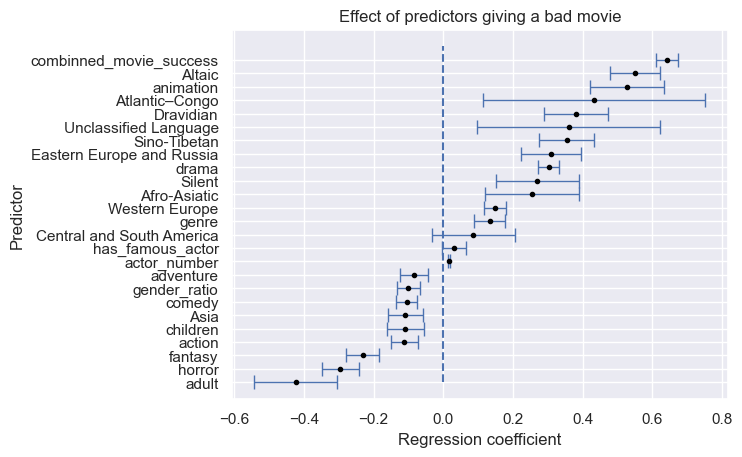

In [58]:
l1, l2, l3 = zip(*sorted(zip(model.params.values[1:], model.params.index[1:], model.bse.values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')
plt.yticks(range(len(l2)),l2)
plt.title("Effect of predictors giving a bad movie")
plt.xlabel("Regression coefficient")
plt.ylabel("Predictor")
plt.show()

---